In [1]:
import os
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, gaussian_kde, linregress, ttest_ind, sem, zscore
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import norm
from scipy.stats import percentileofscore
from sklearn.utils.validation import check_random_state
from math import factorial
from more_itertools import distinct_permutations
import statsmodels.api as sm

import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from tqdm.notebook import tqdm

import warnings
import random
#from torch.utils.data import SubsetRandomSampler
from sklearn.utils import resample

from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from colorama import Fore, Style, init
from sklearn.metrics import roc_auc_score
from collections import Counter

from statsmodels.stats.diagnostic import linear_harvey_collier
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from colorama import Fore, Style, init
from sklearn.metrics import roc_auc_score
from pygam import LinearGAM, s


warnings.filterwarnings("ignore")



## Load data

In [3]:
data = pd.read_parquet('data/BBAG-cross.parquet')
data = data[data.country != 'Slovakia'].reset_index(drop =  True)

In [4]:
Counter(data.country)

Counter({'Austria': 4320,
         'Belgium': 4942,
         'Czechia': 5575,
         'Switzerland': 2634,
         'Germany': 4567,
         'Denmark': 2609,
         'Estonia': 7522,
         'Spain': 4912,
         'France': 3640,
         'Hungary': 3010,
         'Italy': 4541,
         'Netherlands': 2546,
         'Poland': 3612,
         'Portugal': 1914,
         'Sweden': 2792,
         'Slovenia': 5291,
         'Luxembourg': 2104,
         'Greece': 2599,
         'Croatia': 2798,
         'Bulgaria': 1953,
         'Cyprus': 1205,
         'Finland': 1982,
         'Lithuania': 2033,
         'Latvia': 1684,
         'Malta': 1259,
         'Romania': 2083})

## Dispersion

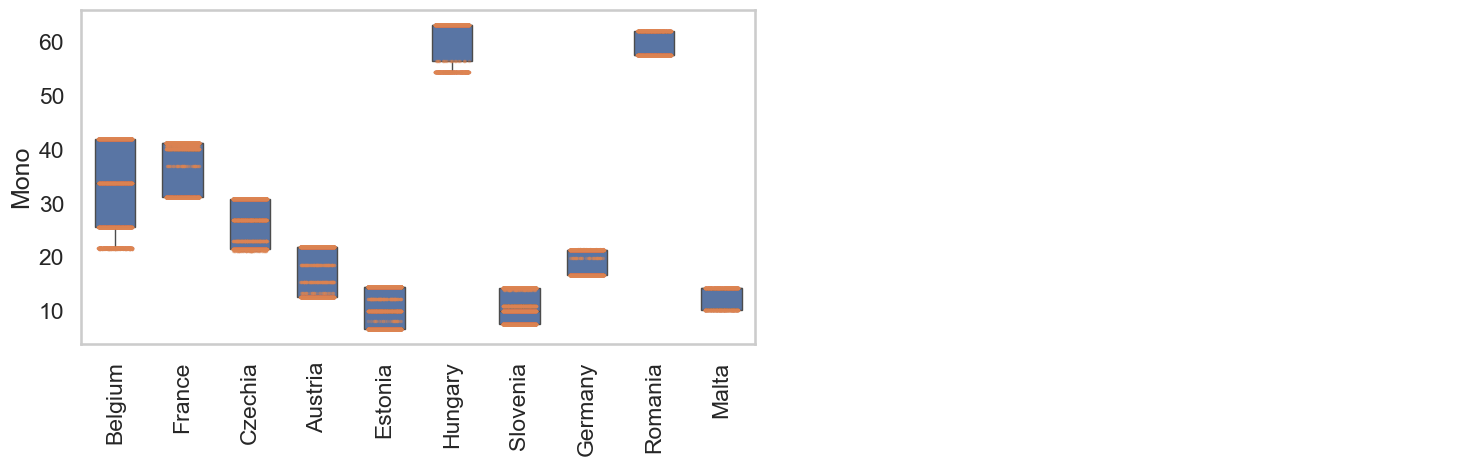

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_parquet('data/BBAG-cross.parquet')
data = data[data.country != 'Slovakia'].reset_index(drop =  True)

vars_ = ["Mono"]#, "One", "Two", "Three", "Total", 'Proficiency']

df = data.copy()
df = df[["country"] + vars_].dropna(subset=["country"]).copy()

top_n = 10          
disp_metric = "iqr" 

df_long = df.melt(id_vars="country", value_vars=vars_, var_name="Feature", value_name="Value")
df_long = df_long.dropna(subset=["Value"]).copy()

def get_order(d, metric="iqr", top_n=20):
    g = d.groupby("country")["Value"]
    if metric == "std":
        disp = g.std()
    else:
        disp = g.quantile(0.75) - g.quantile(0.25)
    order = disp.sort_values(ascending=False).head(top_n).index.tolist()
    return order

sns.set_theme(style="whitegrid", context="talk")

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5), sharey=False)

axes = axes.flatten()

for ax, feat in zip(axes, vars_):
    d = df_long[df_long["Feature"] == feat].copy()
    order = get_order(d, metric=disp_metric, top_n=top_n)
    d = d[d["country"].isin(order)]
    d["country"] = pd.Categorical(d["country"], categories=order, ordered=True)

    sns.boxplot(
        data=d, x="country", y="Value",
        ax=ax, width=0.6
    )
    sns.stripplot(
        data=d, x="country", y="Value",
        ax=ax, size=2.5, alpha=0.35, jitter=0.25
    )

    #ax.set_title(f"{feat} (Top {top_n} dispersion)")
    ax.set_xlabel("")
    ax.set_ylabel(feat)
    ax.tick_params(axis="x", labelrotation=90)
    ax.grid(False)
    

for ax in axes[len(vars_):]:
    ax.axis("off")

plt.tight_layout()


plt.savefig("Figures_pdf/dispersion-plot.pdf", format="pdf", bbox_inches="tight")
plt.savefig("Figures_pdf/dispersion-plot.png", format="png", dpi=300, bbox_inches="tight")

plt.show()


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

# --------------------
# Global style (journal-friendly)
# --------------------
mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 14,
    "axes.linewidth": 1.0
})

COLOR_MONO = "#d62728"    
COLOR_TOTAL = "#1f77b4"  
COLOR_FIT = "#111111"    # near-black
GRID_ALPHA = 0


COL_COUNTRY = "country"
COL_GAP = "GAP_corrected"
COL_MONO = "Mono"
COL_TOTAL = "Proficiency"

# --------------------
# Load & clean
# --------------------
df = data.copy()

required = [COL_COUNTRY, COL_GAP, COL_MONO, COL_TOTAL]

for c in [COL_GAP, COL_MONO, COL_TOTAL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=required)

# --------------------
# Aggregate at country level (correct level!)
# --------------------
country_df = (
    df.groupby(COL_COUNTRY)
      .agg(
          mean_gap=(COL_GAP, "mean"),
          mean_mono=(COL_MONO, "mean"),
          mean_total=(COL_TOTAL, "mean"),
          n=(COL_GAP, "size"),
      )
      .reset_index()
)

# --------------------
# Stats helpers
# --------------------
def corr_text(x, y):
    pear = stats.pearsonr(x, y)
    spear = stats.spearmanr(x, y)
    return (pear.statistic, pear.pvalue, spear.statistic, spear.pvalue)

def add_fit_line(ax, x, y, color=COLOR_FIT):
    slope, intercept, r, p, se = stats.linregress(x, y)
    xline = np.linspace(np.min(x), np.max(x), 200)
    yline = intercept + slope * xline
    ax.plot(xline, yline, linewidth=2, color=color)
    return r, p, slope

def annotate_points(ax, x, y, labels):
    # Small offsets so labels don't sit exactly on points
    dx = 0.004 * (np.max(x) - np.min(x) + 1e-9)
    dy = 0.004 * (np.max(y) - np.min(y) + 1e-9)
    for xi, yi, lab in zip(x, y, labels):
        ax.text(xi + dx, yi + dy, str(lab), fontsize=9)

def quartile_summary(series, values, labels):
    q = pd.qcut(series, 4, labels=labels)
    tmp = pd.DataFrame({"q": q, "val": values})
    out = (tmp.groupby("q")
              .agg(mean=("val", "mean"),
                   sd=("val", "std"),
                   n=("val", "size"))
              .reset_index())
    out["se"] = out["sd"] / np.sqrt(out["n"])
    out["ci95"] = 1.96 * out["se"]
    return out

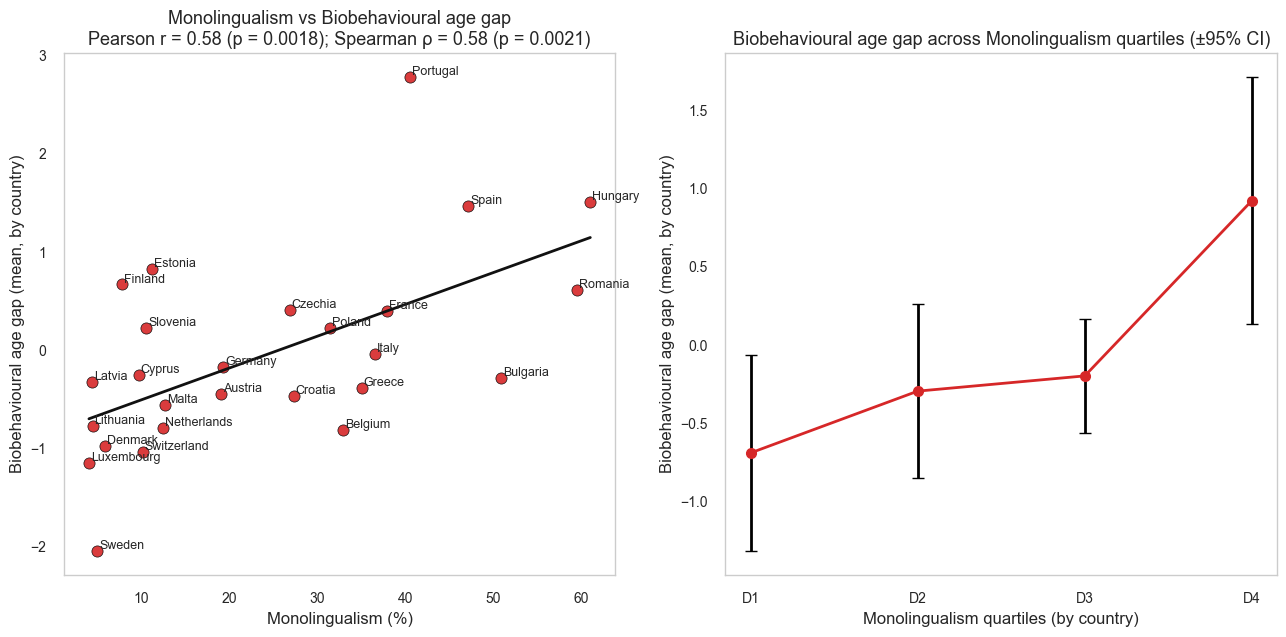

In [8]:
# --------------------
# Prepare correlations
# --------------------
x_mono = country_df["mean_mono"].to_numpy()
x_total = country_df["mean_total"].to_numpy()
y_gap = country_df["mean_gap"].to_numpy()
labels = country_df[COL_COUNTRY].astype(str).to_list()

r_mono, p_mono, rho_mono, ps_mono = corr_text(x_mono, y_gap)
r_total, p_total, rho_total, ps_total = corr_text(x_total, y_gap)

# Quartiles
# Deciles (10-quantiles)
labels_ = [f"D{i}" for i in range(1, 5)]

mono_q = quartile_summary(
    country_df["mean_mono"],
    country_df["mean_gap"],
    labels=labels_
)

total_q = quartile_summary(
    country_df["mean_total"],
    country_df["mean_gap"],
    labels=labels_
)


# --------------------
# Plot: one figure, 4 panels
# --------------------
fig, axes = plt.subplots(1, 2, figsize=(13, 6.5))
ax1, ax2 = axes.flatten()

# (1) Monolingualism scatter with labels + fit
ax1.scatter(
    x_mono, y_gap,
    s=65, alpha=0.9,
    edgecolor="black", linewidth=0.5,
    color=COLOR_MONO
)
annotate_points(ax1, x_mono, y_gap, labels)
add_fit_line(ax1, x_mono, y_gap)

ax1.set_xlabel("Monolingualism (%)")
ax1.set_ylabel("Biobehavioural age gap (mean, by country)")
ax1.set_title(
    "Monolingualism vs Biobehavioural age gap\n"
    f"Pearson r = {r_mono:.2f} (p = {p_mono:.2g}); Spearman ρ = {rho_mono:.2f} (p = {ps_mono:.2g})"
)
ax1.grid(alpha=GRID_ALPHA)



# (3) Monolingualism quartiles (mean ± 95% CI)
ax2.errorbar(
    mono_q["q"], mono_q["mean"], yerr=mono_q["ci95"],
    fmt="o-", capsize=4, linewidth=2, markersize=7,
    color=COLOR_MONO, ecolor="black"
)
ax2.set_xlabel("Monolingualism quartiles (by country)")
ax2.set_ylabel("Biobehavioural age gap (mean, by country)")
ax2.set_title("Biobehavioural age gap across Monolingualism quartiles (±95% CI)")
ax2.grid(alpha=GRID_ALPHA)





plt.tight_layout()
plt.savefig("Figures_pdf/continuous-figures.pdf", format="pdf", bbox_inches="tight")

plt.show()